# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [ ]:
pip install keras

### Load the data into Pandas dataframe

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Type,Message
0,Friendly,"Es ilbcx jinslo zsclb, mnyrk.. Opycxyfxa slxk ..."
1,Friendly,Iq xyn... Zsqclo wch i slc...
2,Friendly,Y til uyk us aynxk vsn... Y m yxnaytk bval uyk...
3,Friendly,"Byv S tsl'b bvclq va osau bs iuh, va xcpau yns..."
4,Hostile,XnaaUuo Lak bvana tynxclo cb'u faal 3 waaq'u l...


Drop the columns that are not required for the neural network.

Understand the distribution better.

Text(0.5, 1.0, 'Number of ham and spam messages')

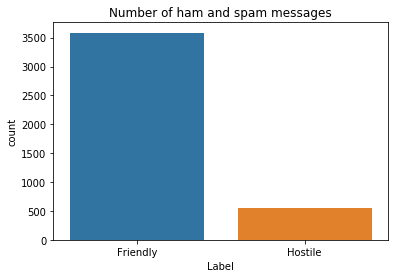

In [4]:
sns.countplot(df.Type)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

* Create input and output vectors.
* Process the labels.

In [5]:
X = df.Message
Y = df.Type
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [7]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### RNN
Define the RNN structure.

In [22]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [23]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Fit on the training data.

In [24]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 2816 samples, validate on 704 samples
Epoch 1/10
2816/2816 [==============================] - 5s 2ms/step - loss: 0.3953 - accuracy: 0.8427 - val_loss: 0.2455 - val_accuracy: 0.8693
Epoch 2/10
2816/2816 [==============================] - 6s 2ms/step - loss: 0.1678 - accuracy: 0.9425 - val_loss: 0.0979 - val_accuracy: 0.9730
Epoch 3/10
2816/2816 [==============================] - 7s 2ms/step - loss: 0.0642 - accuracy: 0.9837 - val_loss: 0.0636 - val_accuracy: 0.9844
Epoch 4/10
2816/2816 [==============================] - 6s 2ms/step - loss: 0.0391 - accuracy: 0.9897 - val_loss: 0.0620 - val_accuracy: 0.9858
Epoch 5/10
2816/2816 [==============================] - 6s 2ms/step - loss: 0.0295 - accuracy: 0.9908 - val_loss: 0.0736 - val_accuracy: 0.9801


The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

In [32]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [33]:
accr = model.evaluate(test_sequences_matrix,Y_test)

622/622 [==============================] - 0s 715us/step


In [47]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.089
  Accuracy: 0.982


In [48]:
df_test = pd.read_csv('test.csv')
df_test.head()

X_test1=df_test['Message']
Y_test1=df_test['Type']

test_sequences1 = tok.texts_to_sequences(X_test1)
test_sequences1_matrix = sequence.pad_sequences(test_sequences1,maxlen=max_len)

In [53]:
p=model.predict(test_sequences1_matrix)

In [57]:
df_p=pd.DataFrame(p)
df_p.to_csv('p.csv')